# Assignment 2

Written by Zitong Li for COMP9418

Group members: 

Zitong Li, z5189688

Alind Vats, z5248806

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [39]:
"""
Written by Zitong Li for COMP9418 assignment 2.
"""

import copy
import re
import math
from collections import OrderedDict as odict
from itertools import product
from functools import reduce

import numpy as np
import pandas as pd
from graphviz import Digraph, Graph
from tabulate import tabulate


class GraphicalModel:
    def __init__(self):
        self.net = dict()
        self.factors = dict()
        self.outcomeSpace = dict()
        self.node_value = dict()

    ####################################
    ######################################
    # Representation
    ########################################
    ##########################################
    def load(self, FileName):
        """
        Load and initiate model from file
        input:
            FileName: String
        """
        self.__init__()
        with open(FileName, 'r') as f:
            content = f.read()
            node_pattern = re.compile(
                r'node (.+) \n\{\n  states = \( \"(.+)\" \);\n\}')
            potential_pattern = re.compile(
                r'potential \( (.+) \) \n\{\n  data = \((.+)\)[ ]?;\n\}')

            nodes_records = node_pattern.findall(content)
            data_records = potential_pattern.findall(content)

            for record in nodes_records:
                outcome = tuple(re.split(r'\" \"', record[1]))
                self.insert(record[0], outcome)
            for record in data_records:
                splits = record[0].split(' | ')
                node = splits[0]
                parents = []
                if len(splits) > 1:
                    parents = list(reversed(splits[1].split()))
                data = [float(i) for i in re.findall(
                    r'[0-1][.][0-9]+', record[1])]
                self.factorize(node, data, parents)

    def connect(self, father, child):
        """
        Connect Two nodes.
        Inputs:
            father: String, name of the father node
            child:  String, name of the child node
        """
        if father in self.net and child in self.net and child not in self.net[father]:
            self.net[father].append(child)

    def disconnect(self, father, child):
        """
        Disconnect Two nodes.
        Inputs:
            father: String, name of the father node
            child:  String, name of the child node
        """
        if father in self.net and child in self.net and child in self.net[father]:
            self.net[father].remove(child)

    def factorize(self, node, data, parents=[]):
        """
        Specify probabilities for a node.
        data is a 1-d array or a simple list.
        Inputs:
            node: Sting, the node you want to specify
            data: 1-D array like, the CPT of the node
            parents: list of strings, parents of the node
        """
        dom = parents + [node]
        dom = tuple(dom)
        for parent in parents:
            self.connect(parent, node)

        self.factors[node] = {'dom': dom, 'table': odict()}
        outcome_product = product(*[self.outcomeSpace[node] for node in dom])
        assert np.prod([len(self.outcomeSpace[node])
                        for node in dom]) == len(data), 'CPT length illegal'
        for i, combination in enumerate(outcome_product):
            self.factors[node]['table'][combination] = data[i]

    def insert(self, Name, Outcome):
        """
        simply insert a node to the graph
        Inputs:
            Outcome: a 1-D array-like, outcome space of this node
            Name:    String, the name of the node
        """
        if Name not in self.net:
            self.net[Name] = []
            self.outcomeSpace[Name] = Outcome
        else:
            print(f'Already have node {Name}')

    def remove(self, node):
        if node in self.net:
            if node in self.factors:
                for child in self.net[node]:
                    if node in self.factors[child]['dom']:
                        self.sum_out(child, node)
                self.factors.pop(node)
            self.net.pop(node)
            self.outcomeSpace.pop(node)
            for other_node in self.net:
                if node in self.net[other_node]:
                    self.net[other_node].remove(node)

    def sum_out(self, node, victim):
        """
        sum out the victim in the factor of node
        Inputs:
            node: String, name of the node
            victim:  String, name of the node to be sum out
        """
        assert victim in self.factors[node]['dom'], 'the node to sum out is not one of the parents'
        f = self.factors[node]
        new_dom = list(f['dom'])
        new_dom.remove(victim)
        table = list()
        for entries in product(*[self.outcomeSpace[node] for node in new_dom]):
            s = 0
            for val in self.outcomeSpace[victim]:
                entriesList = list(entries)
                entriesList.insert(f['dom'].index(victim), val)
                p = f['table'][tuple(entriesList)]
                s = s + p
            table.append((entries, s))
        self.factors[node] = {'dom': tuple(new_dom), 'table': odict(table)}

    def save(self, fileName):
        """
        save the graph to a file
        Inputs:
            fileNamea: String, the path of the file you want to save to.
        """
        f = open(fileName, 'w')
        f.write('net\n{\n}\n')

        # first node domain part
        for node, values in self.outcomeSpace.items():
            outcome = " ".join(
                ['"' + value + '"' for value in values])
            text = 'node %s \n{\n  states = ( %s );\n}\n' % (node, outcome)
            f.write(text)

        # add data
        for node, factor in self.factors.items():
            potential = factor['dom'][-1]
            data = " ".join([str(_) for _ in factor['table'].values()])
            if len(factor['dom']) > 1:
                parents = list(factor['dom'][:-1])
                parents.reverse()
                potential += ' | ' + " ".join(parents)
            text = 'potential ( %s ) \n{\n  data = ( %s );\n}\n' % (
                potential, data)
            f.write(text)
        f.close()

    def printFactor(self, node):
        """
        print the factor table of the node
        """
        f = self.factors[node]
        table = list()
        for key, item in f['table'].items():
            k = list(key)
            k.append(item)
            table.append(k)
        dom = list(f['dom'])
        dom.append('Pr')
        print(tabulate(table, headers=dom, tablefmt='orgtbl'))

    def showGraph(self):
        """
        Visualize the net graph.
        """
        dot = Digraph()
        dot.attr(overlap="False", splines="True")
        for node, children in self.net.items():
            dot.node(node)
            for child in children:
                dot.edge(node, child)
        return dot

    ####################################
    ######################################
    # Pruning and pre-processing techniques for inference
    ########################################
    ##########################################
    def prune(self, query, **evidences):
        """
        Prune the graph based of the query vcariables and evidences
        Inputs:
            query: list of strings, the query variables
            evidences: dictionary, key: node, value: outcome of the node
        Outputs:
            a new graph
        """
        evi_vars = list(evidences.keys())
        qe = set(query + evi_vars)
        assert all([_ in self.net for _ in qe])
        newG = copy.deepcopy(self)
        all_deleted = 0
        # prune nodes
        while not all_deleted:
            all_deleted = 1
            W = set()
            for node, children in newG.net.items():
                if node not in qe and not children:
                    W.add(node)
                    all_deleted = 0
            for leaf in W:
                newG.remove(leaf)
            # clear the child who have been deleted
            for node, children in newG.net.items():
                newG.net[node] = [_ for _ in children if _ not in W]

        # prune edge
        for node, value in evidences.items():
            for child in newG.net[node]:
                newG.factors[child] = self.update(
                    newG.factors[child], node, value, newG.outcomeSpace)
            newG.net[node] = []
            newG.node_value[node] = value

        netcopy = copy.deepcopy(newG.net)
        reachable_from_q = self.spread(self.make_undirected(netcopy), query)
        nodes = list(newG.net.keys())
        for node in nodes:
            if node not in reachable_from_q:
                newG.remove(node)
        return newG

    @staticmethod
    def update(factor, node, value, outcomeSpace):
        """
        Specify a value to a node.
        Inputs:
            factor: the factor of the node
            node: the node to update
            value: the value that will be assigned to the node
            outcomeSpace: Dictionary, the outcome space of all nodes
        Return:
            a new factor without node
        """
        assert node in factor['dom'][:-1], 'such node is not in this CPT'
        assert value in outcomeSpace[node], 'no such value for this node'
        new_dom = copy.copy(factor['dom'])
        factor_outcomeSpace = {node: outcomeSpace[node] for node in new_dom}
        factor_outcomeSpace[node] = (value,)
        node_index = new_dom.index(node)
        new_dom_list = list(new_dom)
        new_dom_list.remove(node)
        new_dom = tuple(new_dom_list)
        new_table = odict()
        valid_records = product(*[_ for _ in factor_outcomeSpace.values()])
        for record in valid_records:
            record_list = list(record)
            record_list.pop(node_index)
            new_record = tuple(record_list)
            new_table[new_record] = factor['table'][record]
        return {'dom': new_dom, 'table': new_table}

    def spread(self, graph, source):
        """
        find all nodes reachable from source
        Inputs:
            graph: Dictionary, the graph
            source: list of strings, the node where we start the spread
        Return:
            visted: a set of strings, the nodes reachabel from source.
        """
        visited = set()
        for node in source:
            self.spread_help(graph, node, visited)
        return visited

    def spread_help(self, graph, node, visited):
        visited.add(node)
        for child in graph[node]:
            if child not in visited:
                self.spread_help(graph, child, visited)

    def make_undirected(self, graph):
        """
        Input:
            graph: a directed graph
        Return:
            an undirected (bidirected) graph
        """
        undirectG = graph.copy()
        GT = self.transposeGraph(graph)
        for node in graph:
            undirectG[node] += GT[node]
        return undirectG

    @staticmethod
    def transposeGraph(G):
        """
        Input:
            graph: a directed graph
        Return:
            a transposed graph
        """
        GT = dict((v, []) for v in G)
        for v in G:
            for w in G[v]:
                if w in GT:
                    GT[w].append(v)
                else:
                    GT[w] = [v]
        return GT

    def min_degree_order(self):
        """
        get the variable elimination from the graph based on min-degree heuristic
        Return:
            prefix: a list of strings, list of variables in the elimination order
            width: the width of the order
        """
        prefix = []
        moral_graph = self.moralize()
        moral_graph.factors = dict()
        width = 0
        while len(moral_graph.net) > 0:
            low = math.inf
            min_degree = math.inf
            for node, neighbors in moral_graph.net.items():
                fill_num = moral_graph.count_fill(node)
                degree = len(moral_graph.net[node])
                if degree < min_degree:
                    min_degree_node = node
                    low = fill_num
                    min_degree = degree
                    width = max(width, degree)
                elif degree == min_degree:
                    if fill_num < low:
                        min_degree_node = node
                        low = fill_num
                        width = max(width, degree)
            moral_graph.remove(min_degree_node)
            prefix.append(min_degree_node)
        return prefix, width

    def min_fill_order(self):
        """
        get the variable elimination from the graph based on min degree heuristic
        Return:
            prefix: a list of strings, list of variables in the elimination order
            width: the width of the order
        """
        prefix = []
        moral_graph = self.moralize()
        moral_graph.factors = dict()
        width = 0
        while len(moral_graph.net) > 0:
            low = math.inf
            min_degree = math.inf
            for node, neighbors in moral_graph.net.items():
                fill_num = moral_graph.count_fill(node)
                degree = len(moral_graph.net[node])
                if fill_num < low:
                    min_fill_node = node
                    low = fill_num
                    min_degree = degree
                    width = max(width, degree)
                elif fill_num == low:
                    if degree < min_degree:
                        min_fill_node = node
                        min_degree = degree
                        width = max(width, degree)
            moral_graph.remove(min_fill_node)
            prefix.append(min_fill_node)
        return prefix, width

    def count_fill(self, node):
        """
        count the fill in edges if eliminate node
        Input:
            node: string, the name of the node to be eliminate
        Return:
            int: fill-in edge count
        """
        neighbors = self.net[node]
        neighbor_num = len(neighbors)
        before = 0
        for neighbor in neighbors:
            for neighbor_s_neighbor in self.net[neighbor]:
                if neighbor_s_neighbor in neighbors:
                    before += 1
        before //= 2
        after = neighbor_num*(neighbor_num-1)//2
        return after - before

    def moralize(self):
        """
        moralize the graph
        return:
            a new moral graph
        """
        new_graph = copy.deepcopy(self)
        graphT = self.transposeGraph(new_graph.net)
        new_graph.net = self.make_undirected(new_graph.net)
        for parents in graphT.values():
            new_graph.connect_all(parents)
        return new_graph

    def connect_all(self, nodes):
        """
        connect every node in nodes to every other node
        """
        for father in nodes:
            for child in nodes:
                if father != child:
                    self.connect(father, child)

    def show_moral_graph(self):
        moral_graph = self.moralize()
        dot = Graph(strict="True")
        for node, children in moral_graph.net.items():
            dot.node(node)
            for child in children:
                dot.edge(node, child)
        return dot

    ####################################
    ######################################
    # Exact inference
    ########################################
    ##########################################
    def to_jointree(self, order):
        """
        self must be a moral graph
        Args:
            order (list): elimination order
        """
        for node, neighbors in self.net.items():
            for neighbor in neighbors:
                assert node in self.net[neighbor], 'the graph is not moral'

        moral_graph = copy.deepcopy(self)
        # 1. construct clusters
        clusters = []
        max_cluster_size = 0
        for node in order:
            cluster = set([node] + moral_graph.net[node])
            moral_graph.connect_all(moral_graph.net[node])
            moral_graph.remove(node)
            if len(cluster) > max_cluster_size:
                max_cluster_size = len(cluster)
            clusters.append(cluster)

        # 2. maitain RIP
        cluster_seq = [tuple(_) for _ in clusters]
        n = len(clusters)
        for cluster in reversed(clusters):
            if len(cluster) < max_cluster_size:
                i = cluster_seq.index(tuple(cluster))
                for pre in reversed(cluster_seq[:i]):
                    if cluster.issubset(pre):
                        cluster_seq.remove(tuple(cluster))
                        cluster_seq.insert(i, pre)
                        cluster_seq.remove(pre)
                        break

        # 3. assembly
        cluster_net = dict()
        cluster_net[cluster_seq[-1]] = []
        n = len(cluster_seq)
        for i in range(n-2, -1, -1):
            cluster_net[cluster_seq[i]] = []
            edge = set(cluster_seq[i+1]).union(
                *[set(_) for _ in cluster_seq[i+2:]]) & set(cluster_seq[i])
            for other in cluster_seq[i+1:]:
                if edge.issubset(other):
                    cluster_net[cluster_seq[i]].append(other)
                    break
        # assign factors to jointree
        factors = dict()
        for cluster in cluster_seq:
            factors[cluster] = self.join(
                *[self.factors[node] for node in cluster])

        return JoinTree(cluster_net, factors, self.outcomeSpace)

    def join(self, *factors):
        common_vars = list(reduce(lambda x, y: x | y, [
                           set(f['dom']) for f in factors]))
        table = list()
        for entries in product(*[self.outcomeSpace[node] for node in common_vars]):
            entryDict = dict(zip(common_vars, entries))
            p = 1
            for f in factors:
                f_entry = tuple(entryDict[var] for var in f['dom'])
                pf = f['table'][f_entry]
                p *= pf
            table.append((entries, p))
        return {'dom': tuple(common_vars), 'table': odict(table)}
    
    ####################################
    ######################################
    # Approximate inference
    ########################################
    ##########################################
    def gibbs_sampling(self, sample_num=100, chain_num=2, q_vars='all', **q_evis):
        """
        gibbs sampling the graph based on query, sample_num and chain_num specified by the user
        Input:
            sample_num: # of samples
            chain_num: # of chains
            q_vars: list of strings, the query variables, defalt is 'all', which means all variables in the graph other than query evidences
            q_evis: dictionary, the query evidences
        Return:
            samples: a list of dictionaries, each one is a sample contains the node and its value in query
        """
        if q_vars == 'all':
            q_vars = [_ for _ in self.net.keys() if _ not in q_evis]
        prunned_graph = self.prune(q_vars, **q_evis)
        chains = prunned_graph.burn_in(chain_num, **q_evis)
        samples = []
        # fisrt sample
        sample = dict()
        for var in q_vars:
            sample[var] = chains[0].node_value[var]
        samples.append(sample)
        curr = 1
        while curr < sample_num:
            sample = dict()
            for var in q_vars:
                chain = chains[np.random.choice(chain_num)]
                pre_value = samples[curr - 1][var]
                value = chain.sample_once(var)
                # A = chain.get_acceptance(var, pre_value, value)
                # sample[var] = np.random.choice(
                #     [value, pre_value], 1, p=[A, 1-A])[0]
                sample[var] = value
            samples.append(sample)
            curr += 1
        return samples

    def get_acceptance(self, node, pre, curr):
        """
        compute the acceptande probability of this sample
        Inputs:
            node: string, the node waiting to be asigned
            pre: string, the previous value assigned to this node
            curr: string, the current value waiting to be assigned to this node
        Return:
            accpt_prob: float, the acceptande probability
        """
        dom = self.factors[node]['dom']
        parents = dom[: -1]
        parents_value = [self.node_value[parent] for parent in parents]
        ppre = self.factors[node]['table'][tuple(parents_value + [pre])]
        pcurr = self.factors[node]['table'][tuple(parents_value + [curr])]
        return min(1, pcurr/ppre)

    def burn_in(self, chain_num, window_size=100, **evidences):
        """
        generate chains and keep sampling until mixed
        Inputs:
            chain_num: int, # of chains
            window_size: int, # of samples used to test if chains are mixed, defalt is 100
            evidences: dictionary, the evidences of the query
        Return:
            chains: list of GraphicalModel objects, the list of mixed chains
        """
        assert chain_num > 1, 'chain num is at least 2'
        chains = []
        chains_non_evis = []
        for seed in range(chain_num):
            np.random.seed(seed)
            chain = copy.deepcopy(self)
            # 1. fix evidence
            chain.node_value = evidences.copy()
            # 2: Initialize other variables
            non_evis = dict()
            for node, domain in self.outcomeSpace.items():
                if node not in evidences:
                    value = np.random.choice(domain, 1)[0]
                    chain.node_value[node] = value
                    non_evis[node] = [value]
            chains.append(chain)
            chains_non_evis.append(non_evis)

        sample_count = 1
        while True:
            if sample_count >= window_size:
                if self.mixed(chains_non_evis, self.outcomeSpace):
                    break
                # clear the chains_non_evis
                chains_non_evis = [{
                    node: []
                    for node in chains_non_evis[i].keys()
                } for i in range(chain_num)]
                sample_count = 0

            # 3: Choose a variable ordering O
            O = np.random.permutation(list(chains_non_evis[0].keys()))
            # 4: Repeat sample non_evis in the order O
            for var in O:
                for i, chain in enumerate(chains):
                    value = chain.sample_once(var)
                    chain.node_value[var] = value
                    chains_non_evis[i][var].append(value)
                sample_count += 1
        return chains

    def sample_once(self, node):
        """
        sample once for a particular node
        Input:
            node: string, name of the node to sample
        Return:
            a string, a value from this node's outcomeSpace
        """
        dom = self.factors[node]['dom']
        parents = dom[: -1]
        parents_value = [self.node_value[parent] for parent in parents]
        combinations = [tuple(parents_value + [node_value])
                        for node_value in self.outcomeSpace[node]]
        prob_list = np.array([self.factors[node]['table'][combination]
                              for combination in combinations])
        prob_list /= np.sum(prob_list)
        return np.random.choice(self.outcomeSpace[node], 1, p=prob_list)[0]

    @staticmethod
    def convert(list_of_dict, outcomeSpace):
        """
        convert the outcome string value from the outcomespace into float value between 0 and 1
        Input:
            list_of_dic: list of dictionary, each key in the dictionary is a variable and corresponding value is the history of its sample value
            outcomeSpace: dictionary, the outcome space of all nodes
        Return:
            list_of_dic, converted list_of_dict
        """
        mapping = dict()
        for node, values in outcomeSpace.items():
            mapping[node] = dict()
            for value in values:
                mapping[node][value] = (values.index(value)+1) / len(values)
        for i, record in enumerate(list_of_dict):
            list_of_dict[i] = {key: [mapping[key][value]
                                     for value in item] for key, item in record.items()}
        return list_of_dict

    def mixed(self, chain_vars, outcomeSpace):
        """
        to judge whether chain_vars are mixed up
        Inputs:
            chain_vars = [
                {a:[...], b:[...] ...},
                {a:[...], b:[...] ...}]
                the history of samples' value
            outcomeSpace: dictionary, the outcome space of all nodes
        Return:
            bool, whether chain_vars are mixed up
        """
        # covert text value into num like value
        chain_vars = self.convert(chain_vars, outcomeSpace)

        parameters = list(chain_vars[0].keys())
        P_hat = []
        df_list = [pd.DataFrame(var_dic) for var_dic in chain_vars]
        concat_df = pd.concat(df_list, ignore_index=True)
        for parm in parameters:
            W = np.mean([df[parm].var() for df in df_list])
            B = concat_df[parm].var()
            p_hat = ((B+0.01)/(W+0.01)) ** 0.5
            P_hat.append(p_hat)
        return all([_ < 1.1 for _ in P_hat])

    def answer_from_samples(self, samples):
        """
        Answer to the query based on the samples
        Input:
            samples: list of dictionary, where keys are variables, value are node's value
        Return:
            pandas dataframe, the probability of every occured combination
        """
        samples = pd.DataFrame(samples)
        answer = samples.groupby(samples.columns.tolist()).size(
        ).reset_index().rename(columns={0: 'prob'})
        answer.prob = answer.prob/answer.prob.sum()
        return answer.sort_values(by=list(answer.columns[:-1]), ascending=False).reset_index(drop=True)


class JoinTree:
    def __init__(self, clusters=dict(), factors=dict(), outcomeSpace=dict()):
        """
        cluster: key: list of node in this cluster, value: neighbor clusters
        """
        self.clusters = clusters
        self.factors = factors
        self.outcomeSpace = outcomeSpace
        self.S = self.get_S(clusters)
        self.messages = dict()

    def get_S(self, clusters):
        S = dict()
        for cluster, nbs in clusters.items():
            for nb in nbs:
                S[tuple(sorted((cluster, nb)))] = set(cluster) & set(nb)
        return S

    def show_jointree(self):
        dot = Graph(strict=True)
        for cluster, neighbors in self.clusters.items():
            dot.node(', '.join(cluster))
            for neighbor in neighbors:
                dot.edge(', '.join(cluster), ', '.join(neighbor))
        return dot

    def add_var(self, var, cluster):
        """add variabel to a cluster, at least one neighbor of the cluster should have this variable

        Args:
            var (string): variable name
            cluster (tuple): cluster
        """
        assert any([var in neighbor for neighbor in self.clusters[cluster]]
                   ), 'at least one neighbor of the cluster should have this variable'
        if var not in cluster:
            old = cluster
            cluster = list(cluster)
            cluster.append(var)
            cluster = tuple(cluster)
            self.clusters[cluster] = self.clusters.pop(old)
            for nb in self.clusters[cluster]:
                self.clusters[nb].remove(old)
                self.clusters[nb].append(cluster)

    def merge(self, cluster1, cluster2):
        """merge two neighboring clusters

        Args:
            cluster1 (list of nodes): cluster1
            cluster2 (list of nodes): cluster2
        """
        assert cluster2 in self.clusters[cluster1] and cluster1 in self.clusters[cluster2], 'clusters are not neighbors'
        assert cluster1 != cluster2
        newcluster = tuple(set(cluster1) | set(cluster2))
        self.clusters[newcluster] = list(
            set(self.clusters.pop(cluster1)) | set(self.clusters.pop(cluster2)))
        self.clusters[newcluster].remove(cluster1)
        self.clusters[newcluster].remove(cluster2)
        for nb in self.clusters[newcluster]:
            print(nb)
            self.clusters[nb].remove(cluster1)
            self.clusters[nb].remove(cluster2)
            self.clusters[nb].append(newcluster)

    def add_cluster(self, cluster, next_to=None):
        """add cluster to an existing cluster

        Args:
            cluster (list of nodes): new added cluster
            next_to (cluster): an existing cluster
        """
        if next_to:
            assert next_to in self.clusters, 'no such cluster'
            assert set(cluster).issubset(
                next_to), 'new added cluster should be a subset of the existing cluster'
        if cluster not in self.clusters:
            self.clusters[cluster] = []
            if next_to:
                self.clusters[cluster].append(next_to)
                self.clusters[next_to].append(cluster)

    def remove(self, cluster):
        """remove a cluster from the jointree

        Args:
            cluster (list of nodes): cluster need to be removed
        """
        if cluster in self.clusters:
            for nb in self.clusters[cluster]:
                self.clusters[nb].remove(cluster)
            self.clusters.pop(cluster)

    def join(self, f1, f2):
        """
        argument 
        `f1`, first factor to be joined.
        `f2`, second factor to be joined.
        `outcomeSpace`, dictionary with the domain of each variable

        Returns a new factor with a join of f1 and f2
        """
        outcomeSpace = self.outcomeSpace
        # First, we need to determine the domain of the new factor. It will be union of the domain in f1 and f2
        # But it is important to eliminate the repetitions
        common_vars = list(f1['dom']) + list(set(f2['dom']) - set(f1['dom']))

        # We will build a table from scratch, starting with an empty list. Later on, we will transform the list into a odict
        table = list()

        # Here is where the magic happens. The product iterator will generate all combinations of varible values
        # as specified in outcomeSpace. Therefore, it will naturally respect observed values
        for entries in product(*[outcomeSpace[node] for node in common_vars]):

            # We need to map the entries to the domain of the factors f1 and f2
            entryDict = dict(zip(common_vars, entries))
            f1_entry = (entryDict[var] for var in f1['dom'])
            f2_entry = (entryDict[var] for var in f2['dom'])

            p1 = f1['table'][tuple(f1_entry)]
            p2 = f2['table'][tuple(f2_entry)]

            # Create a new table entry with the multiplication of p1 and p2
            table.append((entries, p1 * p2))
        return {'dom': tuple(common_vars), 'table': odict(table)}

    def marginalize(self, f, var):
        """
        argument 
        `f`, factor to be marginalized.
        `var`, variable to be summed out.
        `outcomeSpace`, dictionary with the domain of each variable

        Returns a new factor f' with dom(f') = dom(f) - {var}
        """
        outcomeSpace = self.outcomeSpace
        # Let's make a copy of f domain and convert it to a list. We need a list to be able to modify its elements
        new_dom = list(f['dom'])
        new_dom.remove(var)
        table = list()
        for entries in product(*[outcomeSpace[node] for node in new_dom]):
            s = 0

            # We need to iterate over all possible outcomes of the variable var
            for val in outcomeSpace[var]:
                # To modify the tuple entries, we will need to convert it to a list
                entriesList = list(entries)
                # We need to insert the value of var in the right position in entriesList
                entriesList.insert(f['dom'].index(var), val)
                p = f['table'][tuple(entriesList)]
                s = s + p

            # Create a new table entry with the multiplication of p1 and p2
            table.append((entries, s))
        return {'dom': tuple(new_dom), 'table': odict(table)}

    def printFactor(self, f):
        table = list()
        for key, item in f['table'].items():
            k = list(key)
            k.append(item)
            table.append(k)
        dom = list(f['dom'])
        dom.append('Pr')
        print(tabulate(table, headers=dom, tablefmt='orgtbl'))

    def query(self, query):
        """
        argument 
        `factors`, dictionary with all factors.
        `eTree`, elimination tree.
        `messages`, dictionary with messages between neighbouring nodes
        `node`, a node in the elimination tree whose cluster contain the query variables.
        `query`, a list with query variables

        Returns factor with the marginal for the query variables
        """
        factors = self.factors
        eTree = self.clusters
        messages = self.messages
        var = query[0]
        for node in self.clusters:
            if var in node:
                break
        self.getMessages(node)
        # fx is an auxiliary factor. Initialize fx with the factor associated with the root node
        fx = factors[node]
        for v in eTree[node]:
            # Call join to multiply the incomming messages from all nodes but v
            fx = self.join(fx, self.messages[(v, node)])
        for v in fx['dom']:
            if not v in query:
                # Call marginalize to remove variable v from fx domain
                fx = self.marginalize(fx, v)
        return self.normalize(fx)

    def normalize(self, f):
        """
        argument 
        `f`, factor to be normalized.

        Returns a new factor f' as a copy of f with entries that sum up to 1
        """
        table = list()
        sum = 0
        for k, p in f['table'].items():
            sum = sum + p
        for k, p in f['table'].items():
            table.append((k, p/sum))
        return {'dom': f['dom'], 'table': odict(table)}

    def getMessages(self, root):
        """
        argument 
        `factors`, dictionary with all factors.
        `root`, root node.
        `eTree`, elimination tree.
        `S`, separators dictionary.
        `outcomeSpace`, dictionary with the domain of each variable

        Returns dictionary with all messages
        """
        factors = self.factors
        eTree = self.clusters
        S = self.S
        outcomeSpace = self.outcomeSpace
        # For each neighbouring node of root, we start a depth-first search
        for v in eTree[root]:
            # Call pull and store the resulting message in messages[v+root]
            self.messages[(v, root)] = self.pull(v, root)

        # Now, we will do the push part of the code. We implement the code to compute the message root => v
        for v in eTree[root]:
            # messages[root+v] is initalized with the factor at root node
            self.messages[(root, v)] = factors[root]
            # Now, we multiply all incomming messages directed to root but the message from v
            for w in eTree[root]:
                if not v == w:
                    # Call join to multiply the incomming messages from all nodes but v
                    self.messages[(root, v)] = self.join(
                        self.messages[(root, v)], self.messages[(w, root)])
            # This is time to eliminate variables not in the separation between root and v
            for w in self.messages[(root, v)]['dom']:
                if not w in S[tuple(sorted((v, root)))]:
                    # Call marginalize to remove variable v from messages[root+v] domain
                    self.messages[(root, v)] = self.marginalize(
                        self.messages[(root, v)], w)
            # Call push recursively and go to the next node v
            self.push(v, root)

    def pull(self, root, previous):
        """
        argument 
        `root`, current node.
        `previous`, node we came from in the search.
        `factors`, dictionary with all factors.
        `eTree`, elimination tree.
        `S`, separators dictionary.
        `messages`, dictionary with messages.
        `outcomeSpace`, dictionary with the domain of each variable

        Returns a factor fx with a message from node previous to root
        """
        factors = self.factors
        eTree = self.clusters
        S = self.S
        # fx is an auxiliary factor. Initialize fx with the factor associated with the root node
        fx = factors[root]
        # Depth-first search
        for v in eTree[root]:
            # This is an important step: avoid returning using the edge we came from
            if not v == previous:
                # Call pull recursively since root is not an edge with a single neighbour
                self.messages[(v, root)] = self.pull(v, root)
                # Here, we returned from the recursive call.
                # We need to join the received message with fx
                fx = self.join(fx, self.messages[(v, root)])
        # fx has all incomming messages multiplied by the node factor. It is time to marginalize the variables not is S_{ij}
        for v in fx['dom']:
            if not v in S[tuple(sorted((previous, root)))]:
                # Call marginalize to remove variable v from fx's domain
                fx = self.marginalize(fx, v)
        return fx

    def push(self, root, previous):
        """
        argument 
        `root`, factor to be marginalized.
        `previous`, variable to be summed out.
        `factors`, dictionary with all factors.
        `eTree`, elimination tree.
        `S`, separators dictionary.
        `messages`, dictionary with messages.
        `outcomeSpace`, dictionary with the domain of each variable

        Returns a factor fx with a message from node previous to root
        """
        factors = self.factors
        eTree = self.clusters
        S = self.S
        outcomeSpace = self.outcomeSpace
        for v in eTree[root]:
            # This is an important step: avoid returning using the edge we came from
            if not v == previous:
                # Initialize messages[root+v] with the factor associated with the root node
                self.messages[(root, v)] = factors[root]
                for w in eTree[root]:
                    # This is an important step: do not consider the incomming message from v when computing the outgoing message to v
                    if not v == w:
                        # Join messages comming from w into self.messages[(root,v)]
                        self.messages[(root, v)] = join(
                            self.messages[(root, v)], self.messages[(w, root)])

                # self.messages[(root,v)] has all incomming messages multiplied by the node factor. It is time to marginalize the variables not is S_{ij}
                for w in self.messages[(root, v)]['dom']:
                    if not w in S[tuple(sorted((v, root)))]:
                        # Call marginalize to remove variable v from self.messages[(root,v)] domain
                        self.messages[(root, v)] = self.marginalize(
                            self.messages[(root, v)], w)
                # Call push recursively and go to the next node v
                self.push(v, root)


## Representation

### 1. Insert and remove nodes.

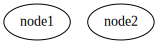

In [3]:
g = GraphicalModel()
g.insert('node1', ('yes', 'no'))
g.insert('node2', ('yes', 'no'))

g.showGraph()

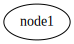

In [4]:
g.remove('node2')
g.showGraph()

### 2. Connect and disconnect nodes with edges.

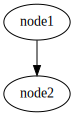

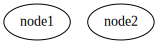

In [5]:
g.insert('node2', ('yes', 'no'))
g.connect('node1', 'node2')
g.showGraph()
g.disconnect('node1', 'node2')
g.showGraph()

### 3. Specify probabilities for a node.

In [6]:
g.connect('node1', 'node2')
g.factorize('node1', [0.1, 0.9])
print(g.factors)
print('node1:')
g.printFactor('node1')
g.factorize('node2', [0.5, 0.5, 0.3, 0.7], ['node1'])
print('node2:')
g.printFactor('node2')

{'node1': {'dom': ('node1',), 'table': OrderedDict([(('yes',), 0.1), (('no',), 0.9)])}}
node1:
| node1   |   Pr |
|---------+------|
| yes     |  0.1 |
| no      |  0.9 |
node2:
| node1   | node2   |   Pr |
|---------+---------+------|
| yes     | yes     |  0.5 |
| yes     | no      |  0.5 |
| no      | yes     |  0.3 |
| no      | no      |  0.7 |


### 4. Save Bayesian network to a file.

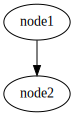

In [7]:
g.save('save_test.net')
g.load('save_test.net')
g.showGraph()

### 5. Load from .net file.

'bayesNet.png'

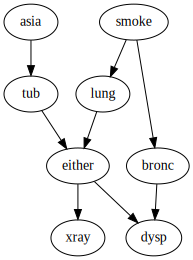

| smoke   | lung   |   Pr |
|---------+--------+------|
| yes     | yes    | 0.1  |
| yes     | no     | 0.9  |
| no      | yes    | 0.01 |
| no      | no     | 0.99 |


In [8]:
g = GraphicalModel()
g.load('small/asia.net')
fig = g.showGraph()
fig.format = 'png'
fig.render('bayesNet')
fig
g.printFactor('lung')

## Pruning and pre-processing techniques for inference

The point of prunning is to find the smallest subgraph of a Bayesian Network that will correctly compute the conditional distribution of a subset of variables in it.

### 1. Network pruning techniques based on query structure.
Suppose our query is P(Q|K), we can prune the network by removing all nodes that are d-seperated from Q by K, and than recursively prune the leaf node that is not in Q $\cup$ K

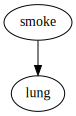

| smoke   | lung   |   Pr |
|---------+--------+------|
| yes     | yes    | 0.1  |
| yes     | no     | 0.9  |
| no      | yes    | 0.01 |
| no      | no     | 0.99 |


In [9]:
pruned_graph = g.prune(['lung'])
pruned_graph.showGraph()
pruned_graph.printFactor('lung')

### 2. Min-fill heuristic for variable order elimination. 

   Deterministic and stochastic composition of min-fill heuristic with min-degree heuristic.
   
   We decide to use **min-fill to select node** and **broke ties stochastically**.

**1. moralize the graph**

'moral.png'

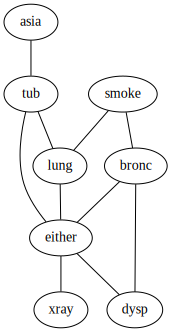

In [10]:
moralfig = g.show_moral_graph()
moralfig.format = 'png'
moralfig.render('moral')
moralfig

**2. eliminate variables based on the Min-fill heuristic.**

Choose the node with smallest fill-in edge num, if fill-in edge num are same, choose the one with smaller degree.

In [11]:
ve_order, width = g.min_fill_order()
ve_order
width

['asia', 'xray', 'tub', 'dysp', 'smoke', 'lung', 'bronc', 'either']

2

## Variable elimination order Benchmark

In [12]:
import time

datas = """small/asia.net,
medium/alarm.net,
large/win95pts.net,
very_large/andes.net,
massive/munin.net"""

min_fill = []
min_degree = []
mf_time = []
md_time = []
for file in datas.split(',\n'):
    g = GraphicalModel()
    g.load(file)
    s = time.time()
    min_fill_order, min_fill_width = g.min_fill_order()
    min_fill_time = time.time() - s
    
    s = time.time()
    min_degree_order, min_degree_width = g.min_degree_order()
    min_degree_time = time.time() - s
    
    min_fill.append(min_fill_width)
    min_degree.append(min_degree_width)
    mf_time.append(1000*min_fill_time)
    md_time.append(1000*min_degree_time)
    print(file + ' done')



small/asia.net done
medium/alarm.net done
large/win95pts.net done
very_large/andes.net done
massive/munin.net done


1. Compare the width of min fill and min degree.

In [13]:
InteractiveShell.ast_node_interactivity = "last_expr"

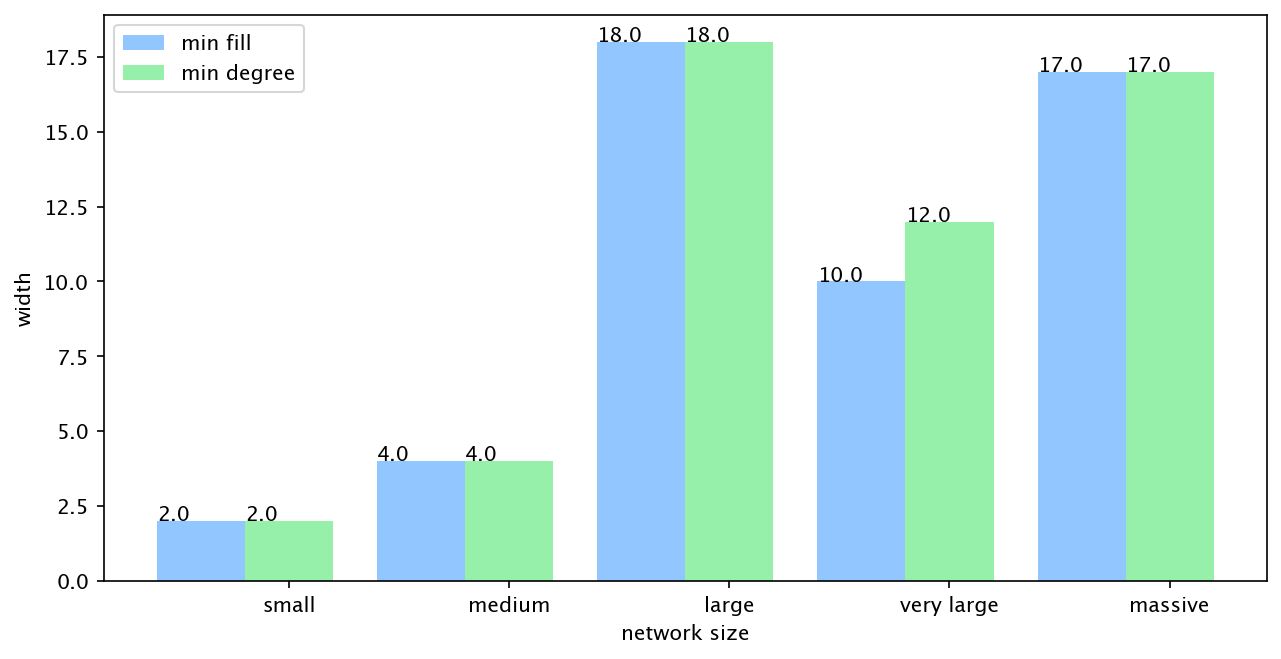

In [35]:
import matplotlib.pyplot as plt
from pylab import style

name_list = ['small', 'medium', 'large', 'very large', 'massive']

x = np.arange(len(name_list))
total_width, n = 0.8, 2
width = total_width / n

style.use('seaborn-pastel')
plt.figure(figsize=(10,5), dpi=150)
a = plt.bar(x, min_fill, width=width, label='min fill')

b = plt.bar(x+width, min_degree, width=width, label='min degree',tick_label = name_list)
plt.xlabel('network size')
plt.ylabel('width')


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x(), height, '%.6s' % float(height))

autolabel(a)
autolabel(b)

plt.legend()
plt.savefig("width.png")
plt.show()

2. Compare the time cost of min fill and min degree.

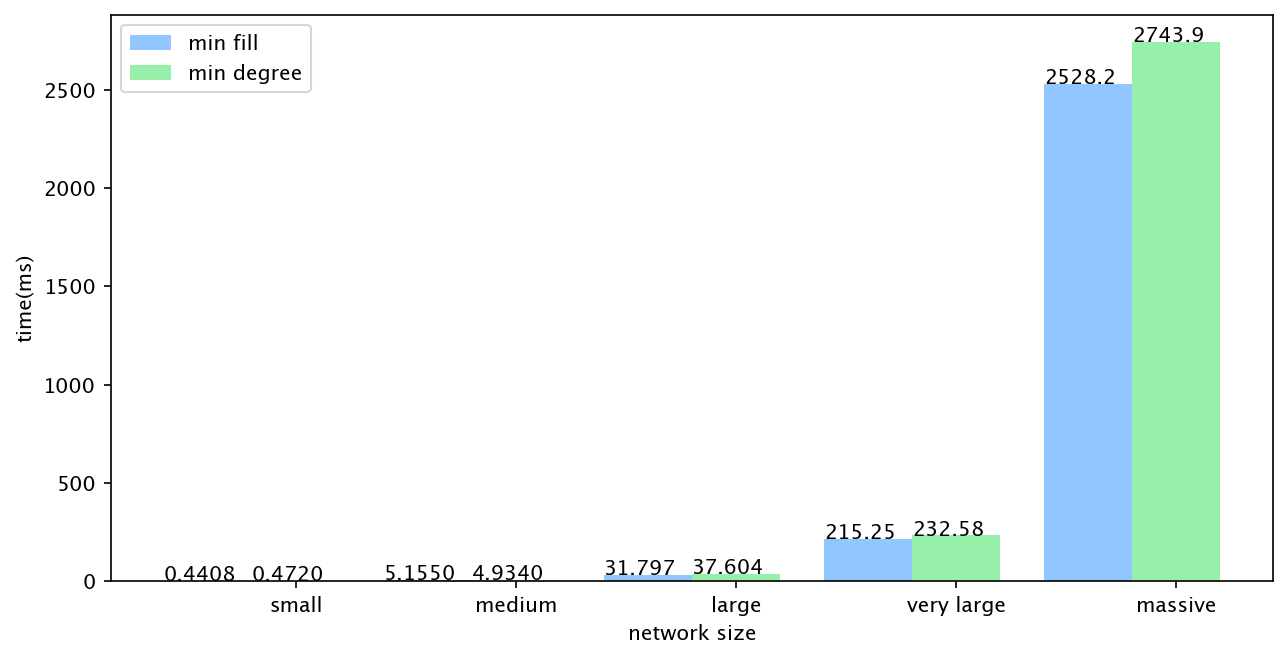

In [38]:
x = np.arange(len(name_list))
total_width, n = 0.8, 2
width = total_width / n

plt.figure(figsize=(10,5), dpi=150)
a = plt.bar(x, mf_time, width=width, label='min fill')

b = plt.bar(x+width, md_time, width=width, label='min degree',tick_label = name_list)

autolabel(a)
autolabel(b)
plt.xlabel('network size')
plt.ylabel('time(ms)')

plt.legend()
plt.savefig("time.png")
plt.show()

## Exact inference

1. A representation for the jointree that can be specified by the user
2. A function that converts an elimination order into a jointree


In [41]:
InteractiveShell.ast_node_interactivity = "all"

moral graph:


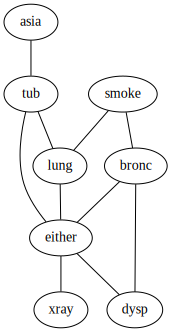

jointree:


'jointree.png'

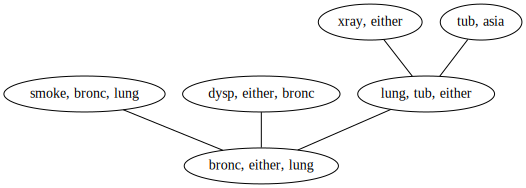

In [42]:
g = GraphicalModel()
g.load('small/asia.net')
moral_graph = g.moralize()
print('moral graph:')
g.show_moral_graph()

jointree = moral_graph.to_jointree(ve_order)
print('jointree:')
jt_fig = jointree.show_jointree()
jt_fig.format = 'png'
jt_fig.render('jointree')
jt_fig

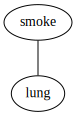

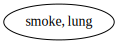

In [43]:
pruned_graph = g.prune(['lung'])
moral_pruned_graph = pruned_graph.moralize()
pruned_graph.show_moral_graph()
pruned_ve_order, width = pruned_graph.min_fill_order()
pruned_jointree = moral_pruned_graph.to_jointree(pruned_ve_order)
pruned_jointree.show_jointree()

3. A function to set evidence

    The evidence value has already been set at the prunning step.

4. A function to answer a query based on the jointree clusters

In [44]:
answer = pruned_jointree.query(['lung'])
pruned_jointree.printFactor(answer)

| lung   |    Pr |
|--------+-------|
| yes    | 0.055 |
| no     | 0.945 |


### JoinTree functions

1. add a cluster


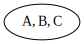

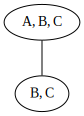

In [20]:
jt = JoinTree()
jt.add_cluster(('A', 'B', 'C'))
jt.show_jointree()
jt.add_cluster(('B', 'C'), next_to=('A', 'B', 'C'))
jt.show_jointree()

2. remove a cluster


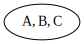

In [21]:
jt.remove(('B', 'C'))
jt.show_jointree()

3. add a variable


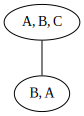

In [22]:
jt.add_cluster(('B'), next_to=('A', 'B', 'C'))
jt.add_var('A', ('B'))
jt.show_jointree()

4. merge two cluster


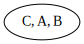

In [23]:
jt.merge(('A','B','C'), ('B', 'A'))
jt.show_jointree()

## Approximate inference

### Gibbs sampling
#### 1. A function that let the user specify the number of chains.
    
   See as `burn_in()` in the class.

In [24]:
chains = g.burn_in(chain_num=5)
for chain in chains:
    print(chain.node_value)

{'asia': 'no', 'tub': 'no', 'smoke': 'yes', 'lung': 'no', 'bronc': 'yes', 'either': 'no', 'xray': 'no', 'dysp': 'no'}
{'asia': 'yes', 'tub': 'no', 'smoke': 'yes', 'lung': 'no', 'bronc': 'yes', 'either': 'no', 'xray': 'no', 'dysp': 'no'}
{'asia': 'no', 'tub': 'no', 'smoke': 'no', 'lung': 'no', 'bronc': 'no', 'either': 'no', 'xray': 'no', 'dysp': 'no'}
{'asia': 'no', 'tub': 'no', 'smoke': 'yes', 'lung': 'no', 'bronc': 'yes', 'either': 'no', 'xray': 'no', 'dysp': 'no'}
{'asia': 'no', 'tub': 'no', 'smoke': 'yes', 'lung': 'no', 'bronc': 'yes', 'either': 'no', 'xray': 'no', 'dysp': 'yes'}


#### 2. A function to mix up chains until convergence.

   See as `burn_in()` in the class. The output of this function are already mixed up chains.
    
    

#### 3. A function that samples the chains for a specified number of samples.

   See as `gibbs_sampling()` in the class.

In [25]:
samples = g.gibbs_sampling(sample_num=1000, chain_num=3, q_vars=['asia'], either='yes')

In [26]:
samplesdf = pd.DataFrame(samples)
samplesdf.describe()

,asia
count,1000
unique,2
top,no
freq,993


#### 4. A function to answer queries based on the samples.

   See as `answer_from_samples()` in the class.

In [27]:
answer = g.answer_from_samples(samples)
answer

,asia,prob
0,yes,0.007
1,no,0.993


In [28]:
g.printFactor('asia')

| asia   |   Pr |
|--------+------|
| yes    | 0.01 |
| no     | 0.99 |


Compared to the CPT, the sampling answer is quite accurate.

## Accuracy benchmark

pick one of the variables in the network as query each time, compare the exact inference result and sampling result.

In [29]:
def get_accuracy(network, sample_num):
    g = GraphicalModel()
    g.load(network)
    accuracy = []
    for var in g.net.keys():
        pruned_g = g.prune([var])
        moral_pruned_g = pruned_g.moralize()
        pruned_ve_order, width = pruned_g.min_fill_order()
        pruned_jointree = moral_pruned_g.to_jointree(pruned_ve_order)
        # exact answer
        exact_answer = pruned_jointree.query([var])
        # sampling answer
        samples = g.gibbs_sampling(sample_num = sample_num, q_vars=[var])
        sample_answer = g.answer_from_samples(samples)
        # compare
        score = compare(exact_answer, sample_answer)
        accuracy.append(score)
    return np.mean(accuracy)

def compare(exact, sample_answer):
    var = sample_answer.columns[0]
    s_records = sample_answer.to_dict('records')
    n = len(s_records)
    s = 0
    for record in s_records:
        outcome = record[var]
        s_prob = record['prob']
        e_prob = exact['table'][(outcome,)]
        diff = abs(s_prob - e_prob)
        s += diff
        
    return 1 - s/n

### Compare the accuracy of samplings using different sample size

This may take a quite long time.

In [30]:
datas = """small/asia.net,
medium/alarm.net,
large/win95pts.net"""

benchmark = dict()
for sample_num in [100, 500, 1000, 5000, 10000]:
    benchmark[sample_num] = []
    for f in datas.split(',\n'):
        a = get_accuracy(f, sample_num)
        benchmark[sample_num].append(a)
        print(f + ' done')


small/asia.net done
medium/alarm.net done
large/win95pts.net done
small/asia.net done
medium/alarm.net done
large/win95pts.net done
small/asia.net done
medium/alarm.net done
large/win95pts.net done
small/asia.net done
medium/alarm.net done
large/win95pts.net done
small/asia.net done
medium/alarm.net done
large/win95pts.net done


In [31]:
InteractiveShell.ast_node_interactivity = "last"

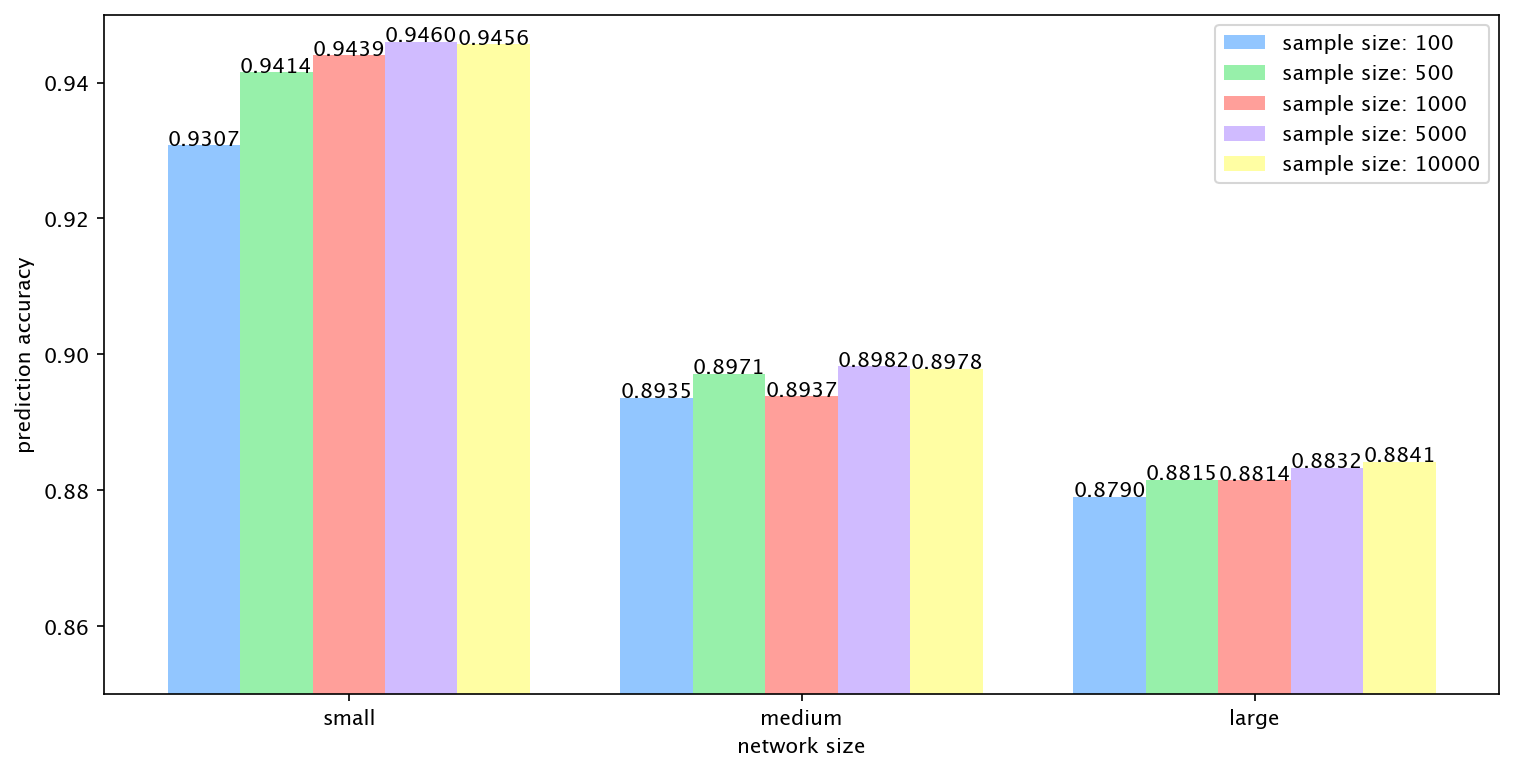

In [32]:

name_list = ['small', 'medium', 'large']

x =list(range(len(name_list)))
total_width, n = 0.8, 5
width = total_width / n

plt.figure(figsize=(12,6), dpi=150)
for num in [100, 500, 1000, 5000, 10000]:
    if num > 100:
        for i in range(len(x)):
            x[i] += width
    if num == 1000:
        bar = plt.bar(x, benchmark[num], width=width, label='sample size: ' + str(num),tick_label = name_list)
    else:
        bar = plt.bar(x, benchmark[num], width=width, label='sample size: ' + str(num))
    autolabel(bar)

plt.ylim((0.85, 0.95))
plt.xlabel('network size')
plt.ylabel('prediction accuracy')

plt.legend()
plt.savefig('accuracy.png')
plt.show()

  **From the bar chart we can make following conclusion:**
  1. When the network size is fixed, increasing the sample size will increase the accuracy.
  2. When the sample size is fixed, the larger scale the network is, the less accurate the prediction will be.

  Cannot get accuracy of networks with size over very large, because we can't get an exact inference in a feasible time.